# Demo: raw spike waveforms from S3
Fetch representative spike waveforms and show how to link them with metadata (injection region, CCF coordinates).

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LCNE_patchseq_analysis import REGION_COLOR_MAPPER
from LCNE_patchseq_analysis.data_util.metadata import load_ephys_metadata
from LCNE_patchseq_analysis.figures import GLOBAL_FILTER
from LCNE_patchseq_analysis.pipeline_util.s3 import get_public_representative_spikes


Raw data directory does not exist: /Users/han.hou/Scripts/LCNE-patchseq-analysis/data/LCNE-patchseq-ephys/raw


## Load the master metadata table
This table provides injection region and CCF coordinates for each ephys ROI.

In [2]:
df_master = load_ephys_metadata(if_from_s3=True, if_with_seq=True)
df_master = df_master.query(GLOBAL_FILTER).copy()
# Show the fields that link waveforms to anatomy.
df_master[["ephys_roi_id", "injection region", "x", "y", "z"]][10:15]


,ephys_roi_id,injection region,x,y,z
72,1380283018,Cortex,10586.672852,4289.566895,4586.5
73,1380296153,Cortex,10802.514648,4129.196777,4586.5
74,1380275537,Cortex,10732.461914,4024.350586,5011.5
75,1380286647,Cortex,10647.876953,4284.354004,5011.5
76,1380304339,Cortex,10658.726562,4117.113281,5011.5


## Fetch representative spikes
Each spike table includes `ephys_roi_id` and `extract_from` columns, followed by waveform timepoints.

In [3]:
spike_types = ["average", "first", "second", "last"]
# Each table has ephys_roi_id and extract_from columns.
spike_tables = {spike_type: get_public_representative_spikes(spike_type) for spike_type in spike_types}
# Flatten the index for easier joins downstream.
for spike_type, df in spike_tables.items():
    df_flat = df.reset_index()
    df_flat["ephys_roi_id"] = df_flat["ephys_roi_id"].astype(str)
    spike_tables[spike_type] = df_flat
{key: table.shape for key, table in spike_tables.items()}


{'average': (1756, 752),
 'first': (1756, 752),
 'second': (885, 752),
 'last': (885, 752)}

In [4]:
spike_tables["average"].head()


ms_to_peak,ephys_roi_id,extract_from,-5.0,-4.98,-4.96,-4.94,-4.92,-4.9,-4.88,-4.86,...,9.8,9.82,9.84,9.86,9.88,9.9,9.92,9.94,9.96,9.98
0,1429103239,"long_square_rheo, min",-65.148438,-65.164062,-65.171875,-65.132812,-65.164062,-65.156250,-65.187500,-65.140625,...,-65.562500,-65.570312,-65.593750,-65.601562,-65.609375,-65.632812,-65.640625,-65.601562,-65.609375,-65.617188
1,1429103239,"long_square_rheo, aver",-61.213234,-61.204659,-61.215687,-61.207722,-61.219975,-61.221813,-61.213848,-61.211395,...,-64.003677,-64.010414,-64.013481,-64.008575,-64.020218,-64.029411,-64.023895,-64.029411,-64.042282,-64.031250
2,1429103239,"long_square_supra, min",-59.093750,-59.079861,-59.090279,-59.069443,-59.090279,-59.069443,-59.069443,-59.086807,...,-62.510418,-62.489582,-62.506943,-62.506943,-62.500000,-62.527779,-62.531250,-62.527779,-62.538193,-62.524307
3,1429103239,"long_square_supra, aver",-54.203976,-54.192047,-54.196022,-54.184090,-54.189205,-54.184658,-54.186932,-54.186363,...,-59.142044,-59.132385,-59.138069,-59.140907,-59.150002,-59.161366,-59.166477,-59.161366,-59.167614,-59.164204
4,1429103239,"subthreshold, aver",-58.812500,-58.781250,-58.875000,-58.875000,-58.843750,-58.906250,-58.906250,-58.875000,...,-56.062500,-56.062500,-56.031250,-56.093750,-56.000000,-56.093750,-56.062500,-56.031250,-56.031250,-56.062500


## Overlay example waveforms
Select a few cells from Cortex- and Spinal-cord projecting groups and overlay their first/second/last spikes.

Step-by-step:
1) Filter metadata to match available waveform IDs.
2) Pick a few units per projection group.
3) Overlay first/second/last spikes with line style encoding.

In [44]:
df_spikes = spike_tables["average"].copy()
available_ids = df_spikes["ephys_roi_id"].astype(str)
# Choose a single stimulus type to keep overlays comparable.
stimulus_type = "long_square_rheo, min"

# Keep metadata only for cells that exist in this waveform table.
df_meta = df_master[df_master["ephys_roi_id"].astype(str).isin(available_ids)].copy()
cortex_ids = df_meta[df_meta["injection region"] == "Cortex"]["ephys_roi_id"].astype(str)
spinal_ids = df_meta[df_meta["injection region"] == "Spinal cord"]["ephys_roi_id"].astype(str)

# Pick a few cells per projection group for overlay.
rng = np.random.default_rng(100)
cortex_pick = rng.choice(cortex_ids, size=3, replace=False)
spinal_pick = rng.choice(spinal_ids, size=3, replace=False)
selected_ids = np.concatenate([cortex_pick, spinal_pick])

df_selected = (
    df_meta[df_meta["ephys_roi_id"].astype(str).isin(selected_ids)]
    .assign(extract_from=stimulus_type)
    .loc[:, ["ephys_roi_id", "injection region", "x", "y", "z", "extract_from"]]
)
df_selected


,ephys_roi_id,injection region,x,y,z,extract_from
60,1438314598,Spinal cord,NaN,NaN,NaN,"long_square_rheo, min"
74,1380275537,Cortex,10732.461914,4024.350586,5011.500000,"long_square_rheo, min"
96,1403204984,Spinal cord,10604.243164,4684.244141,4042.000000,"long_square_rheo, min"
113,1408898882,Spinal cord,NaN,NaN,NaN,"long_square_rheo, min"
164,1424080835,Cortex,10327.606445,4163.746582,6467.117188,"long_square_rheo, min"
167,1425639343,Cortex,10605.549805,4097.986816,4768.121094,"long_square_rheo, min"


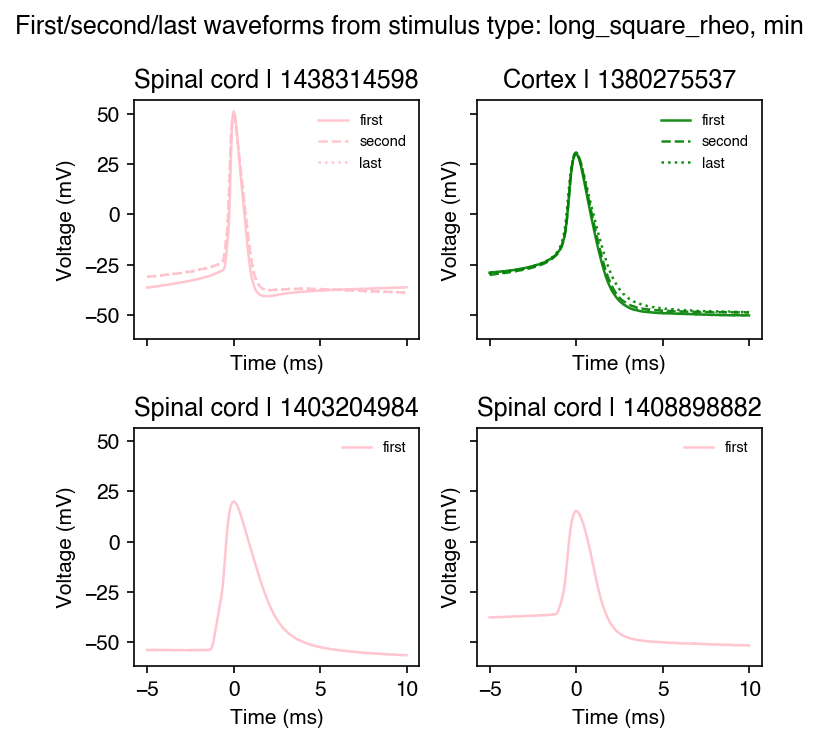

In [45]:
spike_types_to_plot = ["first", "second", "last"]
linestyle_map = {"first": "-", "second": "--", "last": ":"}
df_spikes_first = spike_tables["first"].copy()
# Use the same stimulus for all overlays.
stimulus_type = "long_square_rheo, min"

# One subplot per unit; line style encodes spike position.
fig, axes = plt.subplots(2, 2, figsize=(5, 5), sharex=True, sharey=True, dpi=150)
axes = axes.ravel()

for ax, (_, row) in zip(axes, df_selected.iterrows()):
    ephys_roi_id = str(row["ephys_roi_id"])
    region = row['injection region']
    color = REGION_COLOR_MAPPER.get(region, 'gray')
 
    # Overlay first/second/last spikes for the same unit.
    for spike_type in spike_types_to_plot:
        df_spikes = spike_tables[spike_type].copy()
        row_match = df_spikes[(df_spikes["ephys_roi_id"] == ephys_roi_id) & (df_spikes["extract_from"] == stimulus_type)]
        if row_match.empty:
            continue
        times_ms = row_match.columns.drop(["ephys_roi_id", "extract_from"]).to_numpy(dtype=float)
        waveform = row_match.drop(columns=["ephys_roi_id", "extract_from"]).to_numpy(dtype=float).ravel()
        label = f"{spike_type}"
        ax.plot(
            times_ms,
            waveform,
            linewidth=1.2,
            alpha=0.9,
            color=color,
            linestyle=linestyle_map[spike_type],
            label=label,
        )

    ax.set_title(f"{region} | {ephys_roi_id}")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Voltage (mV)")
    ax.legend(frameon=False, fontsize=7)

for ax in axes[len(df_selected) :]:
    ax.axis("off")

fig.suptitle(f"First/second/last waveforms from stimulus type: {stimulus_type}")
plt.tight_layout()
